In [2]:
# Testing for the first time
from sympy import *
init_printing()

import pandas as pd
import numpy as np

In [24]:
import pandas as pd

# File paths
file_path_bygholm = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Bygholm Skov_DMI.csv"
file_path_hesselballe = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Hesselballe_DMI.csv"
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"

# Read CSVs with correct delimiter and skip headers
bygholm_df = pd.read_csv(file_path_bygholm, skiprows=13, encoding="ISO-8859-1", delimiter=";")
hesselballe_df = pd.read_csv(file_path_hesselballe, skiprows=13, encoding="ISO-8859-1", delimiter=";")
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names (remove leading spaces)
bygholm_df.columns = bygholm_df.columns.str.strip()
hesselballe_df.columns = hesselballe_df.columns.str.strip()
korup_parken_df.columns = korup_parken_df.columns.str.strip()

# Rename columns to match R
bygholm_df.columns = ["timestamp", "NedbørByg", "ksMRK"]
hesselballe_df.columns = ["timestamp", "NedbørHessel", "ksMRK"]
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
bygholm_df["timestamp"] = pd.to_datetime(bygholm_df["timestamp"], format="%d-%m-%Y")
hesselballe_df["timestamp"] = pd.to_datetime(hesselballe_df["timestamp"], format="%d-%m-%Y")
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Merge datasets on timestamp (left join)
merged_df = korup_parken_df.copy()
merged_df = merged_df.merge(bygholm_df[["timestamp", "NedbørByg"]], on="timestamp", how="left")
merged_df = merged_df.merge(hesselballe_df[["timestamp", "NedbørHessel"]], on="timestamp", how="left")

# Remove rows where NedbørByg or NedbørHessel is missing
merged_df = merged_df.dropna(subset=["NedbørByg", "NedbørHessel"])

# Create a sequential Time index
merged_df["Time"] = range(len(merged_df))

# reset index
merged_df = merged_df.reset_index(drop=True)

# Display the cleaned and merged dataset
print(shape(merged_df))
merged_df.head()


(5110, 6)


,timestamp,KarupBro,BygholmPark,NedbørByg,NedbørHessel,Time
0,2010-01-04,1806.75,NaN,0.2,0.2,0
1,2010-01-05,1676.60,NaN,0.6,0.5,1
2,2010-01-06,1562.37,NaN,0.3,0.2,2
3,2010-01-07,1427.74,NaN,0.0,0.1,3
4,2010-01-08,1280.80,NaN,0.0,0.0,4


Epoch 1/50
128/128 [==============================] - 2s 6ms/step - loss: 0.0292 - val_loss: 0.0288
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0280
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0272
Epoch 4/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0259 - val_loss: 0.0259
Epoch 5/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0265
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0262
Epoch 7/50
128/128 [==============================] - 0s 4ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 8/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0265
Epoch 9/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 10/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0246

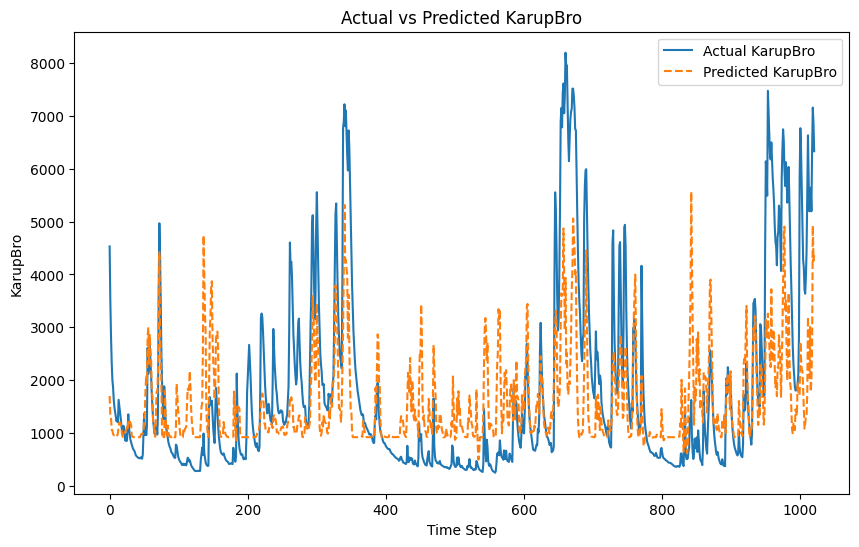

In [27]:
# Creating training and test data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# Prepare data
# Sort by timestamp to ensure time order
merged_df = merged_df.sort_values("timestamp")

# Select features and target
X = merged_df[["NedbørByg", "NedbørHessel"]].values  # Features
y = merged_df["KarupBro"].values  # Target

# Normalize data for neural network training
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create a time-series dataset
def create_time_series(X, y, time_steps):
    X_series, y_series = [], []
    for i in range(time_steps, len(X)):
        X_series.append(X[i - time_steps:i])
        y_series.append(y[i])
    return np.array(X_series), np.array(y_series)

time_steps = 5
X_series, y_series = create_time_series(X_scaled, y_scaled, time_steps=time_steps)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(X_series))
X_train, X_test = X_series[:train_size], X_series[train_size:]
y_train, y_test = y_series[:train_size], y_series[train_size:]

# Build and train LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X_series.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)  # Single output for KarupBro
])

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict and plot results
y_pred = model.predict(X_test)
y_pred_inverse = scaler_y.inverse_transform(y_pred)  # Inverse scale predictions
y_test_inverse = scaler_y.inverse_transform(y_test)  # Inverse scale actual values

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="Actual KarupBro")
plt.plot(y_pred_inverse, label="Predicted KarupBro", linestyle="dashed")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("KarupBro")
plt.title("Actual vs Predicted KarupBro")
plt.show()
